In [ ]:
# Global imports and settings
from preamble import *
%matplotlib inline
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
interactive = True # Set to True for interactive plots 
if interactive:
    plt.rcParams['figure.dpi'] = 150
else:
    plt.rcParams['figure.dpi'] = 100

# Lecture 7. Bayesian Learning

**Learning in an uncertain world**

Joaquin Vanschoren

<img src="../images/frequentists_vs_bayesians.png" alt="ml" style="width: 600px;"/>
XKCD, Randall Monroe

## Bayes' rule
Rule for updating the probability of a hypothesis $c$ given data $x$

<img src="../images/06_bayes_rule.png" alt="ml" style="width: 700px;"/>

$P(c|x)$ is the posterior probability of class $c$ given data $x$.  
$P(c)$ is the _prior_ probability of class $c$: what you believed before you saw the data $x$  
$P(x|c)$ is the _likelihood_ of data point $x$ given that the class is $c$ (computed from your dataset)  
$P(x)$ is the prior probability of the data (_marginal likelihood_): the likelihood of the data $x$ under any circumstance (no matter what the class is)

#### Example
* Let's compute the probability that the sun has exploded
* Prior $P(exploded)$: the sun has an estimated lifespan of 10 billion years, 
  $P(exploded) = \frac{1}{4.38 x 10^{13}}$
* Likelihood that detector lies: $P(lie)= \frac{1}{36}$

$$
\begin{aligned}
P(exploded|yes) &= \frac{P(yes|exploded)P(exploded)}{P(yes)} \\
 &= \frac{(1-P(lie)) P(exploded)}{P(exploded)(1-P(lie))+P(lie)(1-P(exploded))} \\
 &= \frac{1}{1.25226 x 10^{12}}
 \end{aligned}$$
* The one positive observation of the detector increases the probability

#### Example 2
* What is the probability of having COVID-19 if a 96% accurate test returns positive? Assume a false positive rate of 4% 
* Prior $P(C): 0.015$ (117M cases, 7.9B people)
* $P(TP)=P(pos|C)=0.96$, and $P(FP)=(pos|notC)=0.04$
* If test is positive, prior becomes $P(C)=0.268$. 2nd positive test: $P(C|pos)=0.9$

$$
\begin{aligned}
P(C|pos) &= \frac{P(pos|C)P(C)}{P(pos)} \\
 &= \frac{P(pos|C) P(C)}{P(pos|C)P(C)+P(pos|notC)(1-P(C))} \\
 &= \frac{0.96*0.015}{0.96*0.015+0.04*0.985} \\
 &= 0.268
 \end{aligned}$$

## Bayesian models
* Learn the joint distribution $P(x,y)=P(x|y)P(y)$.
    * Assumes that the data is Gaussian distributed (!)
    * With every input $x$ you get $P(y|x)$, hence a mean and standard deviation for $y$ (blue)
    * For every desired output $y$ you get $P(x|y)$, hence you can sample new points $x$ (red)
* Easily updatable with new data using Bayes' rule ('turning the crank')
    * Previous posterior $P(y|x)$ becomes new prior $P(y)$

In [3]:
import scipy.stats as stats
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_joint_distribution(mean,covariance_matrix,x,y,contour=False,labels=['x','y'], plot_intersect=False, ax=None):
    
    delta = 0.05
    xr, yr = np.arange(-3.0, 3.0, delta), np.arange(-3.0, 3.0, delta)
    X, Y = np.meshgrid(xr,yr)
    xy = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    p = stats.multivariate_normal.pdf(xy, mean=mean, cov=covariance_matrix)
    Z = p.reshape(len(X), len(X))
    
    if not ax:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
    if contour:
        ax.plot_surface(X, Y, Z*0.001, alpha=0.9, cmap='jet')
    else:
        ax.plot_surface(X, Y, Z, alpha=0.9, cmap='jet')

    cset = ax.contour(X, Y, Z, zdir='y', offset=3, cmap='Reds')
    cset = ax.contour(X, Y, Z, zdir='x', offset=-3, cmap='Blues')
    Zys = np.zeros_like(Z)
    Zys[60,:] = Z[int((y+3)/delta)]
    cset = ax.contour(X, Y, Zys, zdir='y', offset=3, linewidths=3, cmap='Reds')
    Zys = np.zeros_like(Z)
    Zys[:,60] = Z[int((x+3)/delta)]
    cset = ax.contour(X, Y, Zys, zdir='x', offset=-3, linewidths=3, cmap='Blues')
    
    if plot_intersect:
        ax.plot([x]*len(xr), yr, 0.001, color='k', alpha=1, ls='-', lw=3)
        ax.plot(xr, [y]*len(yr), 0.001, color='k', alpha=1, ls='-', lw=3)
    
    
    ax.set_xlabel(labels[0],fontsize=12)
    ax.set_ylabel(labels[1],fontsize=12)
    ax.set_zlabel('Probability density',fontsize=10)
    ax.set_xticks([-3,0,3])
    ax.set_yticks([-3,0,3])
    ax.set_xlim(xmin=-3, xmax=3)
    ax.set_ylim(ymin=-3, ymax=3)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_zticks([])
    
@interact
def interact_joint_distribution(x=(-3,3,0.5),y=(-3,3,0.5),contour=False):
    # Shape of the joint distribution
    mean = [0, 0]
    covariance_matrix = np.array([[1,-0.8],[-0.8,0.8]])
    plot_joint_distribution(mean,covariance_matrix,x,y,contour, plot_intersect=True)

interactive(children=(FloatSlider(value=0.0, description='x', max=3.0, min=-3.0, step=0.5), FloatSlider(value=…

In [4]:
if not interactive:
    mean = [0, 0]
    covariance_matrix = np.array([[1,-0.8],[-0.8,1]])
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    plot_joint_distribution(mean,covariance_matrix,x=1,y=1,contour=False, plot_intersect=True, ax=ax1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    plot_joint_distribution(mean,covariance_matrix,x=-1,y=1,contour=False, plot_intersect=True, ax=ax2)

### Generative models
* The joint distribution represents the training data for a particular output (e.g. a class)
* You can sample a _new_ point $\textbf{x}$ with high predicted likelihood $P(x,c)$: that new point will be very similar to the training points
* Generate new (likely) points according to the same distribution: _generative model_
    * Generate examples that are _fake_ but corresponding to a desired output
    * Generative neural networks (e.g. GANs) can do this very accurately for text, images, ...

<img src="../images/06_discriminative_generative.png" alt="ml" style="width: 500px"/>

## Naive Bayes

* Predict the probability that a point belongs to a certain class, using Bayes' Theorem

$$P(c|\textbf{x}) = \frac{P(\textbf{x}|c)P(c)}{P(\textbf{x})}$$

* Problem: since $\textbf{x}$ is a vector, computing $P(\textbf{x}|c)$ can be very complex
* Naively  assume that all features are conditionally independent from each other, in which case:  
$P(\mathbf{x}|c) = P(x_1|c) \times P(x_2|c) \times ... \times P(x_n|c)$
* Very fast: only needs to extract statistics from each feature.

### On categorical data

What's the probability that your friend will play golf if the weather is sunny?

<img src="../images/06_bayes_example.png" alt="ml" style="width: 1200px;"/>

## On numeric data
* We need to fit a distribution (e.g. Gaussian) over the data points
* GaussianNB: Computes mean $\mu_c$ and standard deviation $\sigma_c$ of the feature values per class: $p(x=v \mid c)=\frac{1}{\sqrt{2\pi\sigma^2_c}}\,e^{ -\frac{(v-\mu_c)^2}{2\sigma^2_c} }$
    
* We can now make predictions using Bayes' theorem: $p(c \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid c) \ p(c)}{p(\mathbf{x})}$

<img src="../images/06_nb.png" alt="ml" style="width: 500px;"/>

* What do the predictions of Gaussian Naive Bayes look like?

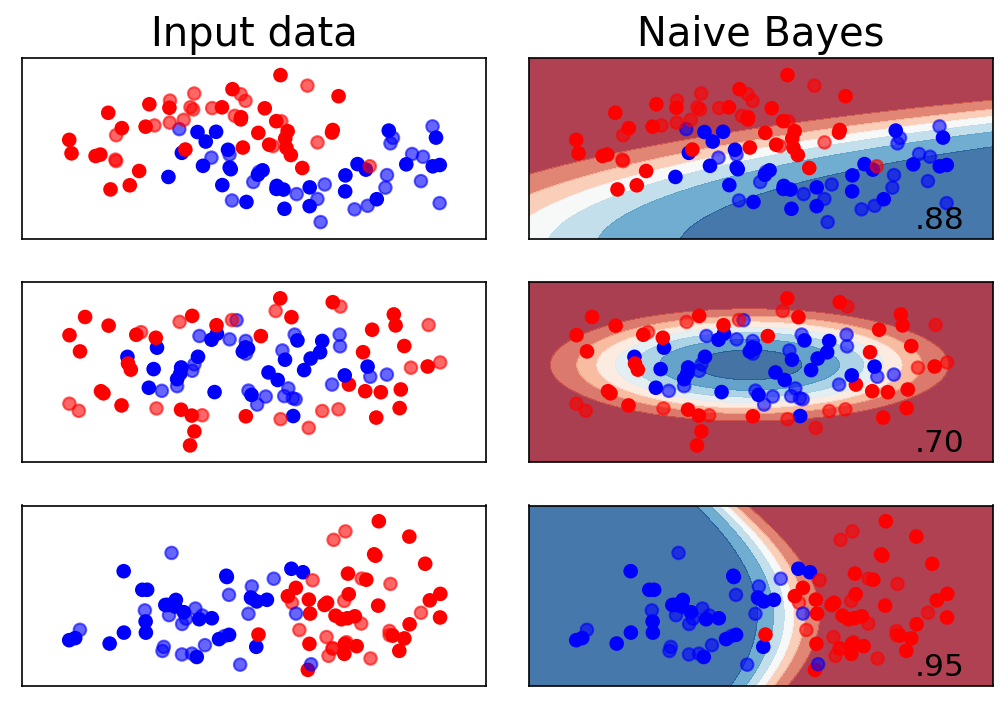

In [5]:
from sklearn.naive_bayes import GaussianNB
import plot_classifiers as pc

names = ["Naive Bayes"]
classifiers = [GaussianNB()]

plt.rcParams.update({'font.size': 16})
pc.plot_classifiers(names, classifiers, figuresize=(7,5))

Other Naive Bayes classifiers:
    
* BernoulliNB
    * Assumes binary data
    * Feature statistics: Number of non-zero entries per class
* MultinomialNB
    * Assumes count data
    * Feature statistics: Average value per class
    * Mostly used for text classification (bag-of-words data)

## Bayesian Networks
* What if we know that some variables are not independent?
* A _Bayesian Network_ is a directed acyclic graph representing variables as nodes and conditional dependencies as edges. 
* If an edge $(A, B)$ connects random variables A and B, then $P(B|A)$ is a factor in the joint probability distribution. We must know $P(B|A)$ for all values of $B$ and $A$
* The graph structure can be designed manually or learned (hard!)    
    

<img src="../images/06_bayesian_network.jpeg" alt="ml" style="width: 500px;"/>


In [6]:
### GP implementation (based on example by Neil Lawrence http://inverseprobability.com/mlai2015/)

# Compute covariances
def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i, :], X2[j, :], **kwargs)
    return K

# Exponentiated quadratic kernel (RBF)
def exponentiated_quadratic(x, x_prime, variance, lengthscale):
    squared_distance = ((x-x_prime)**2).sum()
    return variance*np.exp((-0.5*squared_distance)/lengthscale**2)


class GP():
    def __init__(self, X, y, sigma2, kernel, **kwargs):
        self.K = compute_kernel(X, X, kernel, **kwargs)
        self.X = X
        self.y = y
        self.sigma2 = sigma2
        self.kernel = kernel
        self.kernel_args = kwargs
        self.update_inverse()
    
    def update_inverse(self):
        # Precompute the inverse covariance and some quantities of interest
        ## NOTE: Not the correct *numerical* way to compute this! For ease of use.
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # the log determinant of the covariance matrix.
        self.logdetK = np.linalg.det(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # The matrix inner product of the inverse covariance
        self.Kinvy = np.dot(self.Kinv, self.y)  
        self.yKinvy = (self.y*self.Kinvy).sum()

    def log_likelihood(self):
        # use the pre-computes to return the likelihood
        return -0.5*(self.K.shape[0]*np.log(2*np.pi) + self.logdetK + self.yKinvy)
    
    def objective(self):
        # use the pre-computes to return the objective function 
        return -self.log_likelihood()  
    
    def posterior_f(self, X_test, y):
        K_star = compute_kernel(self.X, X_test, self.kernel, **self.kernel_args)
        K_starstar = compute_kernel(X_test, X_test, self.kernel, **self.kernel_args)
        A = np.dot(self.Kinv, K_star)
        mu_f = np.dot(A.T, y)
        C_f = K_starstar - np.dot(A.T, K_star)
        return mu_f, C_f

# set covariance function parameters
variance = 16.0
lengthscale = 32
sigma2 = 0.05 # noise variance

# Plotting how GPs sample
def plot_gp(X, Y, X_test, nr_points=10, variance=16, lengthscale=32, add_mean=True, nr_samples=25, show_covariance=True, show_stdev=False, ylim=None):
    # Compute GP
    xs, ys = X[:nr_points], Y[:nr_points]
    model = GP(xs, ys, sigma2, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
    mu_f, C_f = model.posterior_f(X_test,ys)

    # Plot GP with or without covariance matrix
    if show_covariance:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        gp_axs = axs[0]
    else:
        fig, axs = plt.subplots(1, 1, figsize=(10, 4))
        gp_axs = axs

    # Plot GP
    if add_mean:
        samples = np.random.multivariate_normal(mu_f.T[0], C_f, nr_samples).T;
    else:
        samples = np.random.multivariate_normal(np.zeros(100), C_f, nr_samples).T;
    
    if not show_stdev:
        for i in range(samples.shape[1]):
            gp_axs.plot(X_test, samples[:,i], lw=1, c='b', ls='-', alpha=0.1);
    gp_axs.plot(X_test, mu_f, lw=2, c='k', ls='-', alpha=0.9); 
        
    gp_axs.plot(xs,ys,'ro')
    gp_axs.set_title("Gaussian Process",fontsize=12)
    gp_axs.set_xlabel("x",fontsize=10)
    gp_axs.set_ylabel("y",fontsize=10)
    gp_axs.tick_params(axis='both', labelsize=10)
    gp_axs.set_ylim(ylim)
    
    # Plot Covariance matrix
    if show_covariance:
        im = axs[1].imshow(C_f, interpolation='none')
        axs[1].set_title("Covariance matrix",fontsize=12)
        fig.colorbar(im);
    
    # Stdev
    if show_stdev:
        var_f = np.diag(C_f)[:, None]
        std_f = np.sqrt(var_f)
        gp_axs.fill(np.concatenate([X_test, X_test[::-1]]),
             np.concatenate([mu_f+2*std_f,
                            (mu_f-2*std_f)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')

## Gaussian processes
* Model the data as a Gaussian distribution, conditioned on the training points

In [7]:
@interact
def plot_sin(nr_points=(0,20,1)):
    X_sin = np.random.RandomState(seed=3).uniform(0,100,(100,1))
    Y_sin = X_sin/100* np.sin(X_sin/5)*3 + np.random.RandomState(seed=0).randn(100,1)*0.5
    X_sin_test = np.linspace(0, 100, 100)[:, None] 
    plot_gp(X_sin,Y_sin,X_sin_test,lengthscale=12, nr_points=nr_points, nr_samples=100, show_covariance=False, ylim=(-7,7))
    
if not interactive:
    plot_sin(nr_points=10)

interactive(children=(IntSlider(value=10, description='nr_points', max=20), Output()), _dom_classes=('widget-i…

## Linear regression (recap)

$$y = f(\mathbf{x}_i) = \mathbf{x}_i\mathbf{w} + b $$

For one input feature: $$y = w_1 \cdot x_1 + b \cdot 1$$

We can solve this via linear algebra (closed form solution): $w^{*} = (X^{T}X)^{-1} X^T Y$

``` python
w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
```

$\mathbf{X}$ is our data matrix with a $x_0=1$ column to represent the bias $b$:

$$\mathbf{X} = \begin{bmatrix} 
\mathbf{x}_1^\top \\\ 
\mathbf{x}_2^\top \\\ 
\vdots \\\
\mathbf{x}_N^\top
\end{bmatrix} = \begin{bmatrix}
1 & x_1 \\\
1 & x_2 \\\
\vdots & \vdots \\\
1 & x_N 
\end{bmatrix},$$

In [8]:
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

X = np.hstack((np.ones_like(x), x)) # [ones(size(x)) x]
w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))

#print("X: ",X[:5])
#print("xTx: ",np.dot(X.T, X))
#print("xTy: ",np.dot(X.T, y))


### Example: Olympic marathon data
We learned: $ y= w_1 x + w_0 = -0.013 x + 28.895$

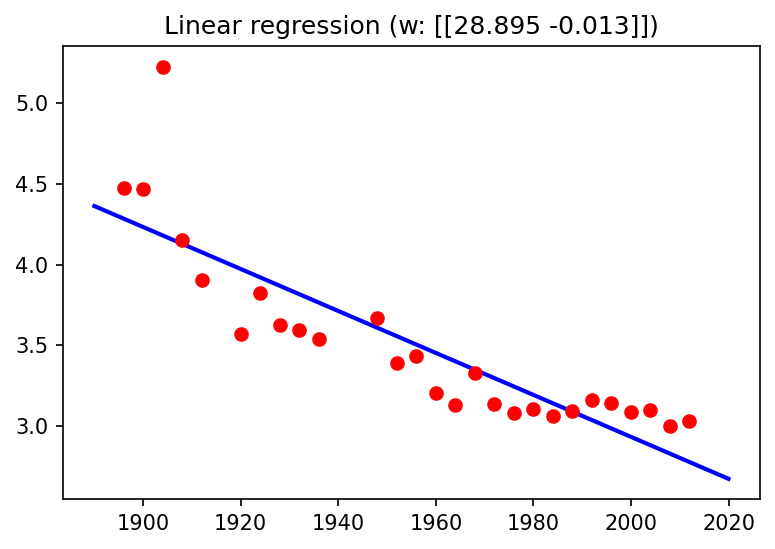

In [9]:
x_test = np.linspace(1890, 2020, 130)[:, None]

f_test = w[1]*x_test + w[0]

plt.plot(x_test, f_test, 'b-', lw=2)
plt.plot(x, y, 'ro');
plt.title("Linear regression (w: {})".format(w.T),fontsize=12)
plt.tick_params(axis='both', labelsize=10)

### Polynomial regression (recap)
We can fit a 2nd degree polynomial by using a basis expansion (adding more _basis functions_):

$$\mathbf{\Phi} = \left[ \mathbf{1} \quad \mathbf{x} \quad \mathbf{x}^2\right]$$

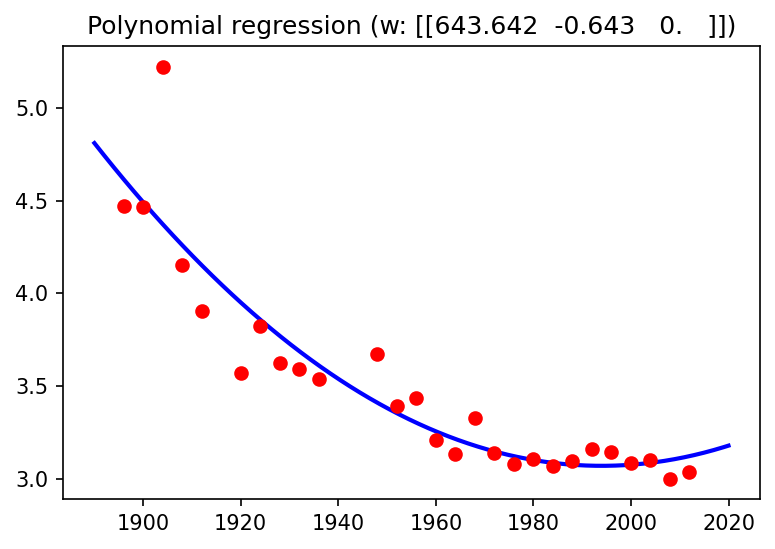

In [10]:
Phi = np.hstack([np.ones(x.shape), x, x**2])
w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))

f_test = w[2]*x_test**2 + w[1]*x_test + w[0]
plt.plot(x_test, f_test, 'b-', lw=2)
plt.plot(x, y, 'ro');
plt.title("Polynomial regression (w: {})".format(w.T),fontsize=12)
plt.tick_params(axis='both', labelsize=10)

### Kernelized regression (recap)
We can also kernelize the model and learn a dual coefficient per data point

In [42]:
from sklearn.kernel_ridge import KernelRidge

@interact
def plot_kernel_ridge(poly_degree=(1,8,1), poly_gamma=(-10,-2,1), rbf_gamma=(-10,-2,1), rbf_alpha=(-10,-5,1)):
    data = pods.datasets.olympic_marathon_men()
    x = data['X']
    y = data['Y']
    x_test = np.linspace(1890, 2020, 130)[:, None]

    plt.rcParams['figure.figsize'] = [8, 4]

    reg = KernelRidge(kernel='poly', degree=poly_degree, gamma=np.exp(poly_gamma)).fit(x, y)
    plt.plot(x_test, reg.predict(x_test), label="Kernel Ridge (Polynomial)", lw=2, c='b')

    reg2 = KernelRidge(kernel='rbf', alpha=np.exp(rbf_alpha), gamma=np.exp(rbf_gamma)).fit(x, y)
    plt.plot(x_test, reg2.predict(x_test), label="Kernel Ridge (RBF)", lw=2, c='g')
    
    plt.plot(x, y, 'ro')
    plt.title("Kernel Ridge",fontsize=12)
    plt.tick_params(axis='both', labelsize=10)
    plt.legend(loc="best");

if not interactive:
    plot_kernel_ridge(poly_degree=4, poly_gamma=-6, rbf_gamma=-6, rbf_alpha=-8)

interactive(children=(IntSlider(value=4, description='poly_degree', max=8, min=1), IntSlider(value=-6, descrip…

## Probabilistic interpretation of regression
* These models do not give us any indication of the (un)certainty of the predictions   
* Assume that the data is inherently uncertain. This can be modeled explictly by introducing a [slack variable](http://en.wikipedia.org/wiki/Slack_variable), $\epsilon_i$, known as noise.

$$y_i = w_1 x_i + w_0 + \epsilon_i.$$

* Assume that the noise is distributed according to a Gaussian distribution with zero mean and variance $\sigma^2$.

$$\epsilon_i \sim \mathcal{N}(0, \sigma^2)$$

* That means that $y(x)$ is now a Gaussian distribution with mean $\mathbf{wx}$ and variance $\sigma^2$

$$y = \mathcal{N}(\mathbf{wx}, \sigma^2)$$




We have an uncertainty predictions, but it is the same for all predictions 
* You would expect to be more certain nearby your training points

In [43]:
from sklearn.linear_model import BayesianRidge

@interact
def plot_regression(sigma=(0.001,0.01,0.001)): 
    data = pods.datasets.olympic_marathon_men()
    x = data['X']
    y = data['Y']
    x_test = np.linspace(1890, 2020, 130)[:, None]
    
    ridge = BayesianRidge(alpha_1=1/sigma).fit(x, y)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'o', c='b')
    # We have the fitted sigma but we're ignoring it for now.
    y_pred, sigma = ridge.predict(x_test, return_std=True)
    plt.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
        
    plt.plot(x_test, y_pred, 'b-', label='Bayesian Ridge')
    plt.tick_params(axis='both', labelsize=10)
    plt.legend(fontsize=10)

interactive(children=(FloatSlider(value=0.005, description='sigma', max=0.01, min=0.001, step=0.001), Output()…

In [13]:
if not interactive:
    plot_regression(sigma=0.001)

# Different ways to learn
* Maximum Likelihood Estimation (MLE): Maximize $P(\textbf{X}|\textbf{w})$
    * Corresponds to optimizing $\mathbf{w}$, using (log) likelihood as the loss function
    * Every prediction has a mean defined by $\textbf{w}$ and Gaussian noise
     $$P(\textbf{X}|\textbf{w}) = \prod_{i=0}^{n} P(\mathbf{y}_i|\mathbf{x}_i;\mathbf{w}) = \prod_{i=0}^{n} \mathcal{N}(\mathbf{wx,\sigma^2 I})$$
* Maximum A Posteriori estimation (MAP): Maximize the posterior $P(\textbf{w}|\textbf{X})$
    * This can be done using Bayes' rule after we choose a (Gaussian) prior $P(\textbf{w})$:
    $$P(\textbf{w}|\textbf{X}) = \frac{P(\textbf{X}|\textbf{w})P(\textbf{w})}{P(\textbf{X})}$$
* Bayesian approach: model the prediction $P(y|x_{test},X)$ directly
    * Marginalize $w$ out: consider all possible models (some are more likely)
    * If prior $P(\textbf{w})$ is Gaussian, then $P(y|x_{test},\textbf{X})$ is also Gaussian!
        * A multivariate Gaussian with mean $\mu$ and covariance matrix $\Sigma$
    $$P(y|x_{test},\textbf{X}) = \int_w P(y|x_{test},\textbf{w}) P(\textbf{w}|\textbf{X}) dw = \mathcal{N}(\mathbf{\mu,\Sigma})$$


## Gaussian prior $P(w)$
In the Bayesian approach, we assume a _prior (Gaussian) distribution_ for the parameters, $\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})$:
* With zero mean ($\mu$=0) and covariance matrix $\alpha \mathbf{I}$. For 2D: $ \alpha \mathbf{I} = \begin{bmatrix}
\alpha & 0 \\
0 & \alpha
\end{bmatrix}$

I.e, $w_i$ is drawn from a Gaussian density with variance $\alpha$
$$w_i \sim \mathcal{N}(0,\alpha)$$

In [14]:
@interact
def interact_prior(alpha=(0.1,1,0.1),contour=False):
    # Shape of the joint distribution
    mean = [0, 0]
    covariance_matrix = np.array([[alpha,0],[0,alpha]])
    plot_joint_distribution(mean,covariance_matrix,0,0,contour,labels=['w1','w2'])

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, min=0.1), Checkbox(value=False, des…

In [15]:
if not interactive:
    interact_prior(0.5,contour=False)

### Sampling from the prior (weight space)

We can sample from the prior distribution to see what form we are imposing on the functions *a priori* (before seeing any data). 

* Draw $w$ (left) independently from a Gaussian density $\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha\mathbf{I})$
    * Use any normally distributed sampling technique, e.g. Box-Mueller transform
* Every sample yields a polynomial function $f(\mathbf{x})$ (right): $f(\mathbf{x}) = \mathbf{w} \boldsymbol{\phi}(\mathbf{x}).$ 
    * For example, with $\boldsymbol{\phi}(\mathbf{x})$ being a polynomial:

In [46]:
alpha = 4. # set prior variance on w
degree = 5 # set the order of the polynomial basis set
sigma2 = 0.01 # set the noise variance
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1880, 2030, num_pred_data)[:, None] # input locations for predictions
cmap = plt.get_cmap('jet')
    
# Build the basis matrices (on Olympics data)
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

@interact
def plot_function_space(alpha=(0.1,5,0.5),degree=(1,10,1),random=(0,10,1)):
    data = pods.datasets.olympic_marathon_men()
    x = data['X']
    y = data['Y']
    
    scale = np.max(x) - np.min(x)
    loc = np.min(x) + 0.5*scale
    x_pred = np.linspace(1880, 2030, num_pred_data)[:, None] # input locations for predictions

    Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
    Phi = polynomial(x, degree=degree, loc=loc, scale=scale)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    num_samples = 10
    K = degree+1
    colors = [cmap(i) for i in np.linspace(0, 1, num_samples)]
    for i in range(num_samples):
        z_vec = np.random.normal(size=(K, 1))
        w_sample = z_vec*np.sqrt(alpha)
        f_sample = np.dot(Phi_pred,w_sample)
        axs[0].scatter(w_sample[0], w_sample[1], color=colors[i])
        axs[0].set(xlabel="w_1", ylabel="w_2")
        axs[1].plot(x_pred, f_sample, ls='-', c=colors[i], lw=2) 
        axs[0].set_xlim(xmin=-5, xmax=5)
        axs[0].set_ylim(ymin=-5, ymax=5)
        axs[1].set_ylim(ymin=-5, ymax=5)
        axs[0].tick_params(axis='both', labelsize=10)
        axs[1].tick_params(axis='both', labelsize=10)

        
    x1 = np.linspace(-5, 5, 100)
    X1, X2 = np.meshgrid(x1, x1)
    xy = np.hstack((X1.flatten()[:, None], X2.flatten()[:, None]))
    p = stats.multivariate_normal.pdf(xy, mean=[0,0], cov=[[alpha,0],[0,alpha]])
    P = p.reshape(len(X1), len(X2))
    axs[0].contour(X1, X2, P)


interactive(children=(FloatSlider(value=2.1, description='alpha', max=5.0, min=0.1, step=0.5), IntSlider(value…

In [17]:
if not interactive:
    plot_function_space(alpha=4, degree=5, random=0)

### Learning Gaussian distributions

* We assume that our data is Gaussian distributed
    $$P(y|x_{test},\textbf{X}) = \mathcal{N}(\mathbf{\mu,\Sigma})$$

* Example with learned mean $[m,m]$ and covariance
$\begin{bmatrix}
\alpha & \beta \\
\beta & \alpha
\end{bmatrix}$
    * The blue curve is the predicted $P(y|x_{test},\textbf{X})$


In [18]:
@interact
def interact_prior(x_test=(-3,3,0.5),m=(-0.5,0.5,0.1),alpha=(0.5,1,0.1),beta=(-0.5,0.5,0.1),contour=False):
    # Shape of the joint distribution
    mean_matrix = [m, m]
    covariance_matrix = np.array([[alpha,beta],[beta,alpha]])
    plot_joint_distribution(mean_matrix,covariance_matrix,x_test,0,contour,plot_intersect=True,labels=['x_test','y'])

interactive(children=(FloatSlider(value=0.0, description='x_test', max=3.0, min=-3.0, step=0.5), FloatSlider(v…

In [19]:
if not interactive:
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    m,alpha,beta = 0,1,0
    mean_matrix = [m, m]
    covariance_matrix = np.array([[alpha,beta],[beta,alpha]])
    ax1.set_title("m=0, alpha=1, beta=0",fontsize=12)
    plot_joint_distribution(mean_matrix,covariance_matrix,0,0,contour=False,labels=['x_test','y'], ax=ax1)
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    m,alpha,beta = 1,0.5,0.3
    mean_matrix = [m, m]
    covariance_matrix = np.array([[alpha,beta],[beta,alpha]])
    ax2.set_title("m=1, alpha=0.5, beta=0.3",fontsize=12)
    plot_joint_distribution(mean_matrix,covariance_matrix,0,0,contour=False, labels=['x_test','y'], ax=ax2)

### Understanding covariances
* If two variables $x_i$ covariate strongly, knowing about $x_1$ tells us a lot about $x_2$  
* If covariance is 0, knowing $x_1$ tells us nothing about $x_2$ (the conditional and marginal distributions are the same) 
* For covariance matrix
$\begin{bmatrix}
1 & \beta \\
\beta & 1
\end{bmatrix}$:

In [20]:
@interact
def interact_covariance(x1=(-3,3,0.5),x2=(-3,3,0.5),beta=(-0.9,0.9,0.1)):
    # Shape of the joint distribution
    mean = [0, 0]
    covariance_matrix = np.array([[1,beta],[beta,1]])
    plot_joint_distribution(mean,covariance_matrix,x1,x2,contour=True, plot_intersect=True, labels=['x1','x2'])

interactive(children=(FloatSlider(value=0.0, description='x1', max=3.0, min=-3.0, step=0.5), FloatSlider(value…

In [21]:
if not interactive:
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    mean = [0, 0]
    covariance_matrix = np.array([[1,0],[0,1]])
    ax1.set_title("beta=0",fontsize=12)
    plot_joint_distribution(mean,covariance_matrix,1,1,contour=True, plot_intersect=True, labels=['x1','x2'], ax=ax1)
 
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    covariance_matrix = np.array([[1,0.9],[0.9,1]])
    ax2.set_title("beta=0.9",fontsize=12)
    plot_joint_distribution(mean,covariance_matrix,1,1,contour=True, plot_intersect=True, labels=['x1','x2'], ax=ax2)

## Sampling from higher-dimensional distributions

* Instead of sampling $\mathbf{w}$ and then multiplying by $\boldsymbol{\Phi}$, we can also generate examples of $f(x)$ directly. 
* $\mathbf{f}$ with $n$ values can be sampled from an $n$-dimensional Gaussian distribution with zero mean and covariance matrix $\mathbf{K} = \alpha \boldsymbol{\Phi}\boldsymbol{\Phi}^\top$:
    * $\mathbf{f}$ is a _stochastic process_: series of normally distributed variables (interpolated in the plot)
    
$$\mathbf{f} \sim \mathcal{N}(\mathbf{0},\mathbf{K})$$

In [41]:
from matplotlib.ticker import MaxNLocator

# Exponentiated quadratic is another name for RBF
def exponentiated_quadratic(x, x_prime, variance, lengthscale):
    squared_distance = ((x-x_prime)**2).sum()
    return variance*np.exp((-0.5*squared_distance)/lengthscale**2)

# Compute covariances directly
def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i, :], X2[j, :], **kwargs)
    return K

def plot_process(alpha=1, dimensions=100, num_samples=5, phi="Polynomial", sigma2=0.01, noise=False, length_scale=10.):
    x_pred = np.linspace(0, dimensions-1, dimensions)[:, None] # input locations for predictions
    if phi == "Identity":
        K = alpha*np.eye(dimensions)
    elif phi == "RBF":
        K = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=alpha, lengthscale=length_scale)
    else:
        if phi == "Polynomial":
            degree = 5  
        elif phi == "Linear":
            degree = 1
        scale = np.max(x_pred) - np.min(x_pred)
        loc = np.min(x_pred) + 0.5*scale
        Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
        K = alpha*np.dot(Phi_pred, Phi_pred.T)
    if noise:
        K += sigma2*np.eye(x_pred.size)
    
    if dimensions==2:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        ax_d, ax_s, ax_c = axs[0], axs[1], axs[2]
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        ax_s, ax_c = axs[0], axs[1]

    im = ax_c.imshow(K, interpolation='none')
    ax_c.set_title("Covariance matrix",fontsize=12)
    ax_c.tick_params(axis='both', labelsize=10)
    ax_c.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_c.yaxis.set_major_locator(MaxNLocator(integer=True))
    fig.colorbar(im);
    
    samples = np.random.RandomState(seed=4).multivariate_normal(np.zeros(dimensions), K, num_samples).T;
    colors = [cmap(i) for i in np.linspace(0, 1, num_samples)]
    for i in range(samples.shape[1]):
        ax_s.plot(x_pred, samples[:,i], lw=2, color=colors[i], ls='-');
    ax_s.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_s.set_title("Interpolated samples from Gaussian",fontsize=12)
    ax_s.set_xlabel("X")
    ax_s.tick_params(axis='both', labelsize=10)
    ax_s.set_aspect(1./ax_s.get_data_ratio())
    
    if dimensions==2:
        ax_d.scatter(samples[0],samples[1], color=colors)    
        x1 = np.linspace(-2.5, 2.5, 100)
        X1, X2 = np.meshgrid(x1, x1)
        xy = np.hstack((X1.flatten()[:, None], X2.flatten()[:, None]))
        p = stats.multivariate_normal.pdf(xy, mean=[0,0], cov=K)
        P = p.reshape(len(X1), len(X2))
        ax_d.contour(X1, X2, P)
        ax_d.tick_params(axis='both', labelsize=10)
        ax_d.set_aspect(1./ax_d.get_data_ratio())
        ax_d.set_xlabel("x0")
        ax_d.set_ylabel("x1")
        ax_d.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax_d.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_d.set_title("Samples from 2D Gaussian",fontsize=12)
    
@interact
def plot_process_noiseless(alpha=(0.1,2,0.1), dimensions=(2,100,1), phi=["Identity","Linear","Polynomial"]):
    plot_process(alpha=alpha, dimensions=dimensions, phi=phi, noise=False)

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, min=0.1), IntSlider(value=51, descr…

In [23]:
if not interactive:
    plot_process(alpha=1, dimensions=2, phi="Polynomial")

Repeat for 40 dimensions, with $\boldsymbol{\Phi}$ the polynomial transform:

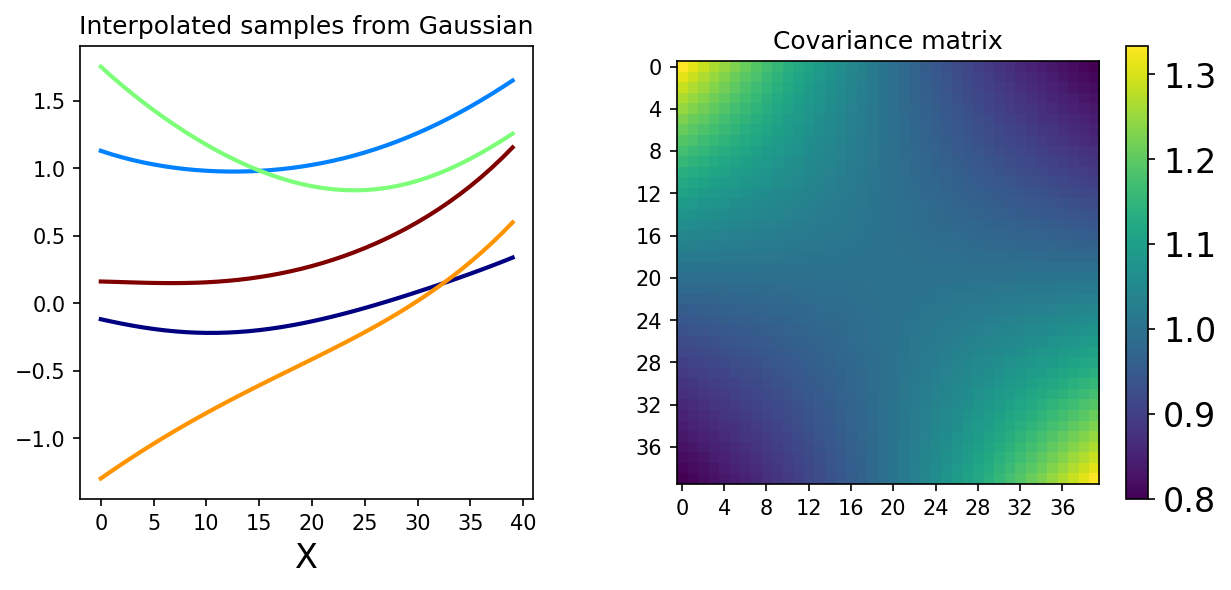

In [24]:
plot_process(alpha=1, dimensions=40, phi="Polynomial")

[More examples of covariances](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-covariances.html)

### Noisy functions

We normally add Gaussian noise to obtain our observations: 
$$
\mathbf{y} = \mathbf{f} + \boldsymbol{\epsilon}
$$

In [25]:
@interact
def plot_covm_noise(sigma=(0.01,0.1,0.01)):
    plot_process(alpha=1, dimensions=100, phi="Polynomial", sigma2=sigma, noise=True)

interactive(children=(FloatSlider(value=0.05, description='sigma', max=0.1, min=0.01, step=0.01), Output()), _…

In [26]:
if not interactive:
    plot_process(alpha=1, dimensions=100, phi="Polynomial", sigma2=0.02, noise=True)

## Gaussian Process

* Usually, we want our functions to be _smooth_: if two points are similar/nearby, the predictions should be similar.
    * Hence, we need a similarity measure (a kernel)
* In a Gaussian process we can do this by specifying the *covariance function* directly (not as $\mathbf{K} = \alpha \boldsymbol{\Phi}\boldsymbol{\Phi}^\top$)
    * The covariance matrix is simply the kernel matrix: $\mathbf{f} \sim \mathcal{N}(\mathbf{0},\mathbf{K})$
* The RBF (Gaussian) covariance function (or _kernel_) is specified by

$$
k(\mathbf{x}, \mathbf{x}^\prime) = \alpha \exp\left( -\frac{\left\Vert \mathbf{x}-\mathbf{x}^\prime\right\Vert^2}{2\ell^2}\right).
$$

where $\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2$ is the squared distance between the two input vectors 

$$
\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2 = (\mathbf{x} - \mathbf{x}^\prime)^\top (\mathbf{x} - \mathbf{x}^\prime) 
$$

and the length parameter $l$ controls the smoothness of the function and $\alpha$ the vertical variation.

Now the influence of a point decreases smoothly but exponentially
* These are our priors  $P(y) = \mathcal{N}(\mathbf{0,\mathbf{K}})$, with mean 0
* We now want to condition it on our training data: $P(y|x_{test},\textbf{X}) = \mathcal{N}(\mathbf{\mu,\Sigma})$


In [27]:
@interact
def plot_gprocess(alpha=(0.1,2,0.1), lengthscale=(1,20,1), dimensions=(2,100,1), nr_samples=(1,21,5)):
    plot_process(alpha=alpha, dimensions=dimensions, phi="RBF", length_scale=lengthscale, num_samples=nr_samples)
    
if not interactive:
    plot_gprocess(alpha=1, lengthscale=10, dimensions=100, nr_samples=12)

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, min=0.1), IntSlider(value=10, descr…

## Computing the posterior $P(\mathbf{y}|\mathbf{X})$

* Assuming that $P(X)$ is a Gaussian density with a covariance given by kernel matrix $\mathbf{K}$, the model likelihood becomes:
$$
P(\mathbf{y}|\mathbf{X}) = \frac{P(y) \ P(\mathbf{X} \mid y)}{P(\mathbf{X})} = \frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{K}|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}\mathbf{y}^\top \left(\mathbf{K}+\sigma^2 \mathbf{I}\right)^{-1}\mathbf{y}\right)
$$

* Hence, the negative log likelihood (the objective function) is given by:
$$
E(\boldsymbol{\theta}) = \frac{1}{2} \log |\mathbf{K}| + \frac{1}{2} \mathbf{y}^\top \left(\mathbf{K} + \sigma^2\mathbf{I}\right)^{-1}\mathbf{y}
$$

* The model parameters (e.g. noise variance $\sigma^2$) and the kernel parameters (e.g. lengthscale, variance) can be embedded in the covariance function and learned from data.

* Good news: This loss function can be optimized using linear algebra (Cholesky Decomposition)
* Bad news: This is cubic in the number of data points AND the number of features: $\mathcal{O}(n^3 d^3)$

``` python
class GP():
    def __init__(self, X, y, sigma2, kernel, **kwargs):
        self.K = compute_kernel(X, X, kernel, **kwargs)
        self.X = X
        self.y = y
        self.sigma2 = sigma2
        self.kernel = kernel
        self.kernel_args = kwargs
        self.update_inverse()
    
    def update_inverse(self):
        # Precompute the inverse covariance and some quantities of interest
        ## NOTE: Not the correct *numerical* way to compute this! For ease of use.
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # the log determinant of the covariance matrix.
        self.logdetK = np.linalg.det(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # The matrix inner product of the inverse covariance
        self.Kinvy = np.dot(self.Kinv, self.y)  
        self.yKinvy = (self.y*self.Kinvy).sum()

        
    def log_likelihood(self):
        # use the pre-computes to return the likelihood
        return -0.5*(self.K.shape[0]*np.log(2*np.pi) + self.logdetK + self.yKinvy)
    
    def objective(self):
        # use the pre-computes to return the objective function 
        return -self.log_likelihood()  
```

## Making predictions
The model makes predictions for $\mathbf{f}$ that are unaffected by future values of $\mathbf{f}^*$.  
If we think of $\mathbf{f}^*$ as test points, we can still write down a joint probability density over the training observations, $\mathbf{f}$ and the test observations, $\mathbf{f}^*$. 

This joint probability density will be Gaussian, with a covariance matrix given by our kernel function, $k(\mathbf{x}_i, \mathbf{x}_j)$. 
$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

where $\mathbf{K}$ is the kernel matrix computed between all the training points,  
$\mathbf{K}_\ast$ is the kernel matrix computed between the training points and the test points,  
$\mathbf{K}_{\ast,\ast}$ is the kernel matrix computed between all the tests points and themselves. 

Analogy

The joint probability of two variable $x_1$ and $x_2$ following a multivariate Gaussian is: 
$$
\begin{bmatrix}x_1 \\ x_2 \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$


## Conditional Density $P(\mathbf{y}|x_{test} , \mathbf{X})$

Finally, we need to define *conditional* distributions to answer particular questions of interest

We will need the *conditional density* for making predictions.
$$
\mathbf{f}^* | \mathbf{y} \sim \mathcal{N}(\boldsymbol{\mu}_f,\mathbf{C}_f)
$$
with a mean given by
$
\boldsymbol{\mu}_f = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$  

and a covariance given by 
$
\mathbf{C}_f = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_\ast.
$

In [28]:
model = GP(x, y, sigma2, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
mu_f, C_f = model.posterior_f(x_pred, y)

### Gaussian process example
We can now get the mean and covariance learned on our dataset, and sample from this distribution!

In [29]:
def shuffled_olympics():
    data = pods.datasets.olympic_marathon_men()
    X = data['X']
    Y = data['Y']
    perm = np.random.RandomState(seed=0).permutation(len(X))
    x_shuffle, y_shuffle = X[perm], Y[perm]
    X_test = np.linspace(1890, 2020, 100)[:, None]
    return x_shuffle, y_shuffle, X_test

@interact
def plot_gp_olympics(nr_points=(0,27,1)):
    x, y, xt = shuffled_olympics()
    plot_gp(x, y, xt, lengthscale=12, nr_points=nr_points, nr_samples=100, show_covariance=True, ylim=(-4,8))
    
if not interactive:
    plot_gp_olympics(nr_points=13)

interactive(children=(IntSlider(value=13, description='nr_points', max=27), Output()), _dom_classes=('widget-i…

Remember that our prediction is the sum of the mean and the variance: $P(\mathbf{y}|x_{test} , \mathbf{X}) = \mathcal{N}(\mathbf{\mu,\Sigma})$  
* The mean is the same as the one computed with kernel ridge (if given the same kernel and hyperparameters)
* The Gaussian process learned the covariance and the hyperparameters

In [30]:
@interact
def plot_gp_olympics_mean(nr_points=(0,27,1), add_mean=False):
    x, y, xt = shuffled_olympics()
    plot_gp(x, y, xt, lengthscale=12, nr_points=nr_points, add_mean=add_mean, nr_samples=100, show_covariance=True, ylim=(-4,8))
    
if not interactive:
    plot_gp_olympics_mean(nr_points=13)

interactive(children=(IntSlider(value=13, description='nr_points', max=27), Checkbox(value=False, description=…

The values on the diagonal of the covariance matrix give us the variance, so we can simply plot the mean and 95% confidence interval

In [31]:
@interact
def plot_gp_olympics_stdev(nr_points=(0,27,1), lengthscale=(4,20,1)):
    x, y, xt = shuffled_olympics()
    plot_gp(x, y, xt, lengthscale=lengthscale, nr_points=nr_points, nr_samples=100, show_covariance=True, show_stdev=True, ylim=(-4,8))
    
if not interactive:
    plot_gp_olympics_stdev(nr_points=13,  lengthscale=12)

interactive(children=(IntSlider(value=13, description='nr_points', max=27), IntSlider(value=12, description='l…

## Gaussian Processes with GPy
- `GPyRegression`
- Generate a kernel first
    - State the dimensionality of your input data
    - Variance and lengthscale are optional, default = 1
```
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
```
    - Other kernels:
```
GPy.kern.BasisFuncKernel?
```
- Build model:
```
m = GPy.models.GPRegression(X,Y,kernel)
```


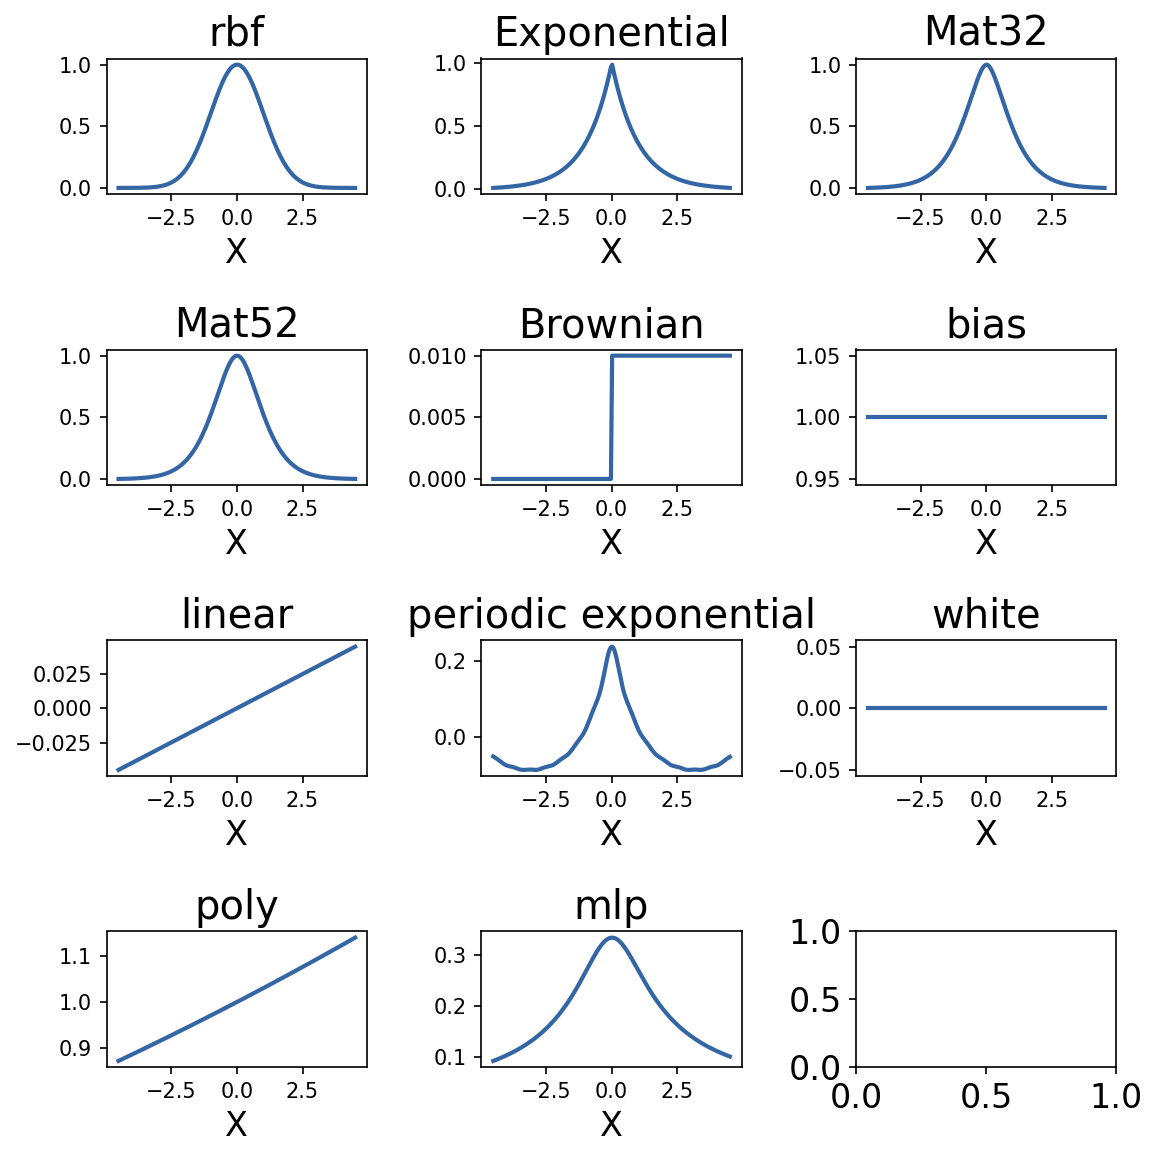

In [32]:
figure, axes = plt.subplots(4,3, figsize=(8,8), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), 
         GPy.kern.Matern52(1), GPy.kern.Brownian(1),GPy.kern.Bias(1), 
         GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1), 
         GPy.kern.Poly(1), GPy.kern.MLP(1)]
 
for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=0.01)
    a.set_title(k.name.replace('_', ' '))
    a.tick_params(axis='both', labelsize=10)
    a.set_ylabel("")

`Matern` is a generalized RBF kernel that can scale between RBF and Exponential

Build the untrained GP. The shaded region corresponds to ~95% confidence intervals (i.e. +/- 2 standard deviation)

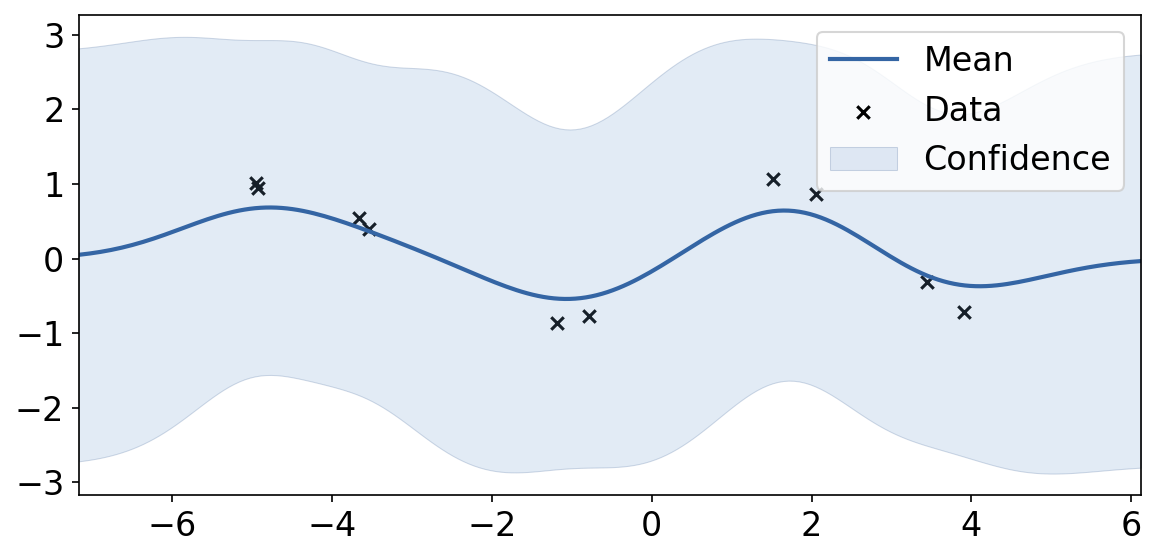

In [33]:
# Generate noisy sine data
X = np.random.uniform(-5.,5.,(10,1))
Y = np.sin(X) + np.random.randn(10,1)*0.05

# Build untrained model
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.) 
m = GPy.models.GPRegression(X,Y,kernel)
fig = m.plot()

Train the model (optimize the parameters): maximize the likelihood of the data.  
Best to optimize with a few restarts: the optimizer may converges to the high-noise solution. The optimizer is then restarted with a few random initialization of the parameter values.  

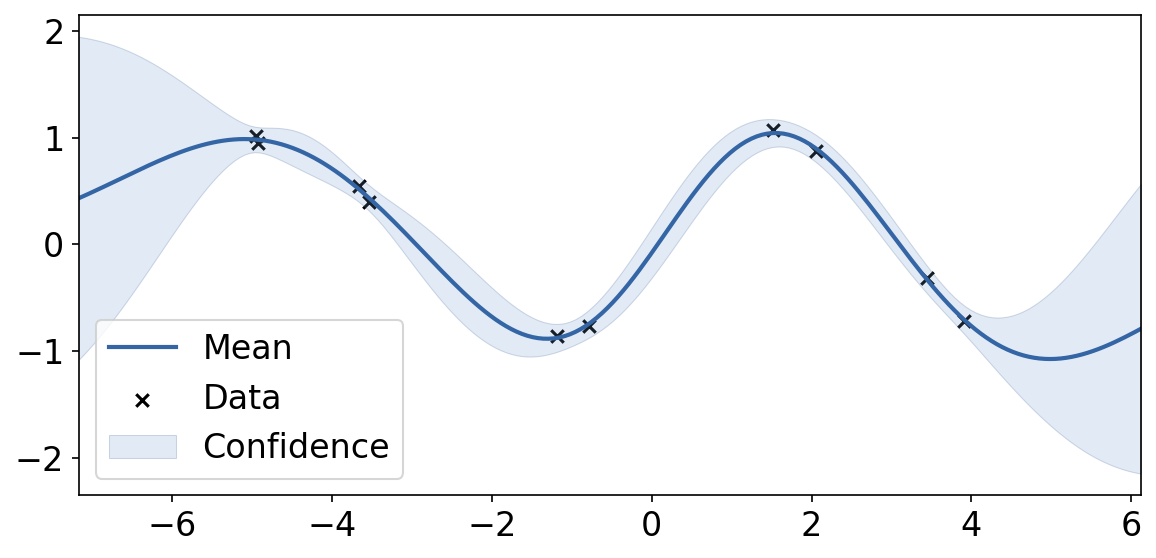

In [34]:
m.optimize_restarts(num_restarts = 3, verbose=0)
fig = m.plot()

You can also plot densities

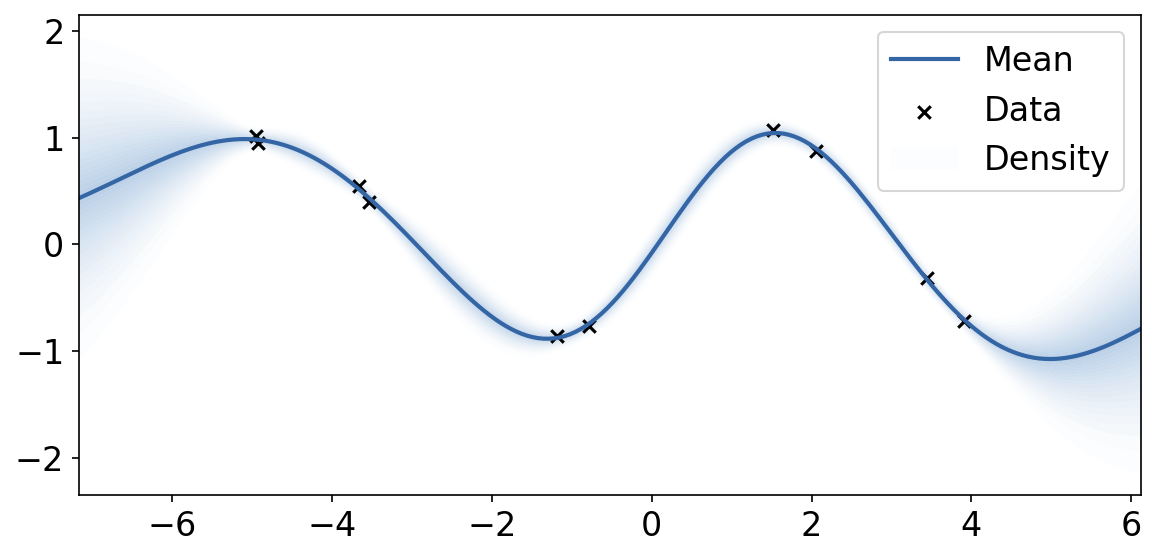

In [35]:
fig = m.plot(plot_density=True)

You can also show results in 2D

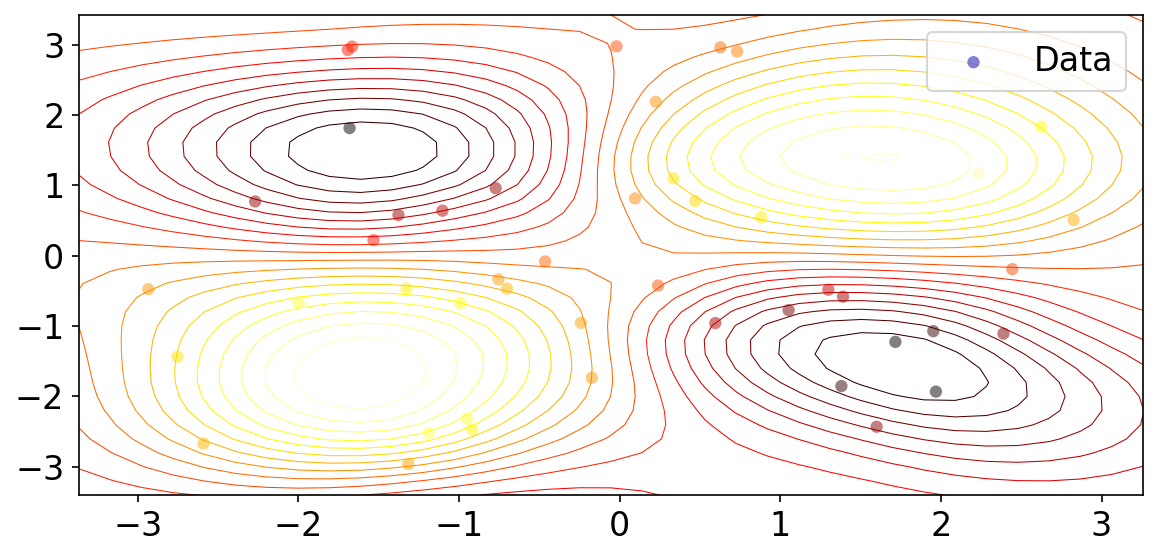

In [36]:
# sample inputs and outputs
X = np.random.uniform(-3.,3.,(50,2))
Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05 
ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(max_f_eval = 1000)
fig = m.plot()

We can plot 2D slices using the `fixed_inputs` argument to the plot function.  
`fixed_inputs` is a list of tuples containing which of the inputs to fix, and to which value.

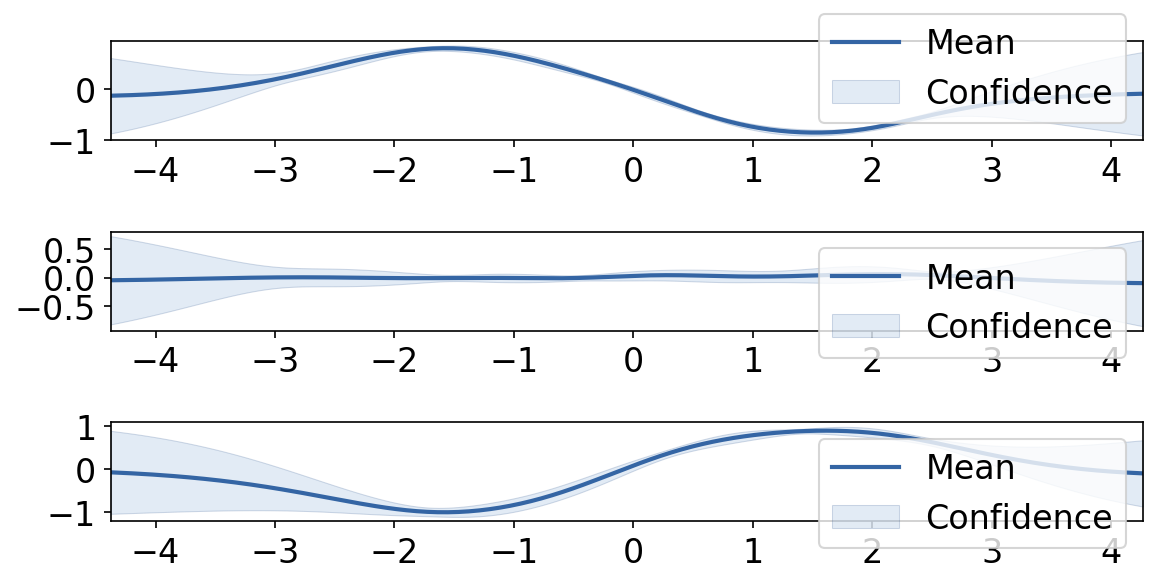

In [37]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)

For vertical slices, simply fix the other input: `fixed_inputs=[(0,y)]`

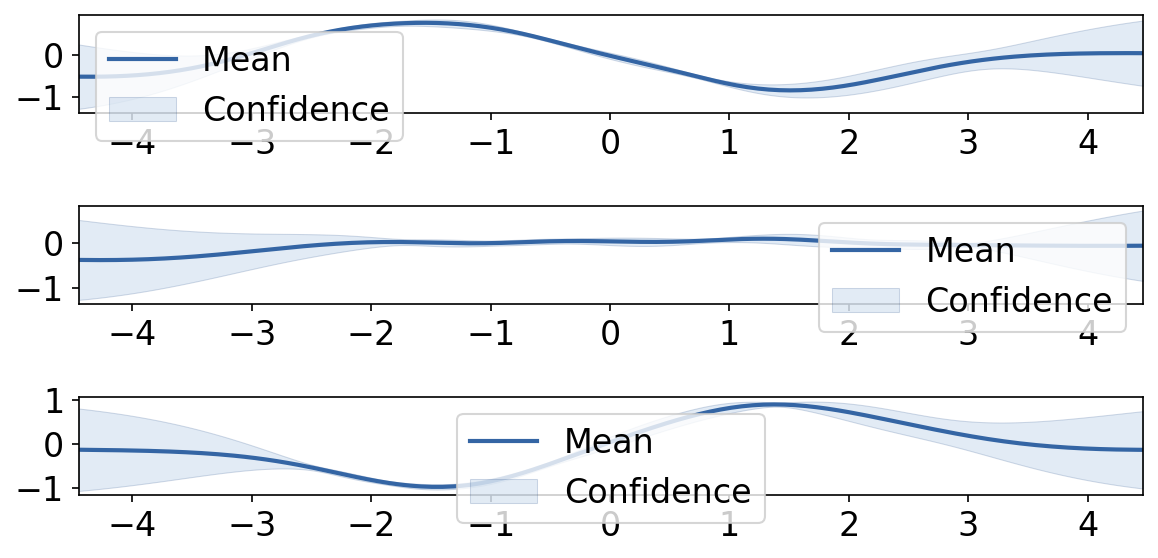

In [38]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1)
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)

## Gaussian Processes with scikit-learn
- `GaussianProcessRegressor`
- Hyperparameters:
    - `kernel`: kernel specifying the covariance function of the GP
        - Default: "1.0 * RBF(1.0)"
        - Typically leave at default. Will be optimized during fitting
    - `alpha`: regularization parameter 
        - Tikhonov regularization of covariance between the training points.
        - Adds a (small) value to diagonal of the kernel matrix during fitting. 
        - Larger values:
            - correspond to increased noise level in the observations
            - also reduce potential numerical issues during fitting
        - Default: 1e-10
    - `n_restarts_optimizer`: number of restarts of the optimizer
        - Default: 0. Best to do at least a few iterations.
        - Optimizer finds kernel parameters maximizing log-marginal likelihood
- Retrieve predictions and confidence interval after fitting:
```
y_pred, sigma = gp.predict(x, return_std=True)
```

Example

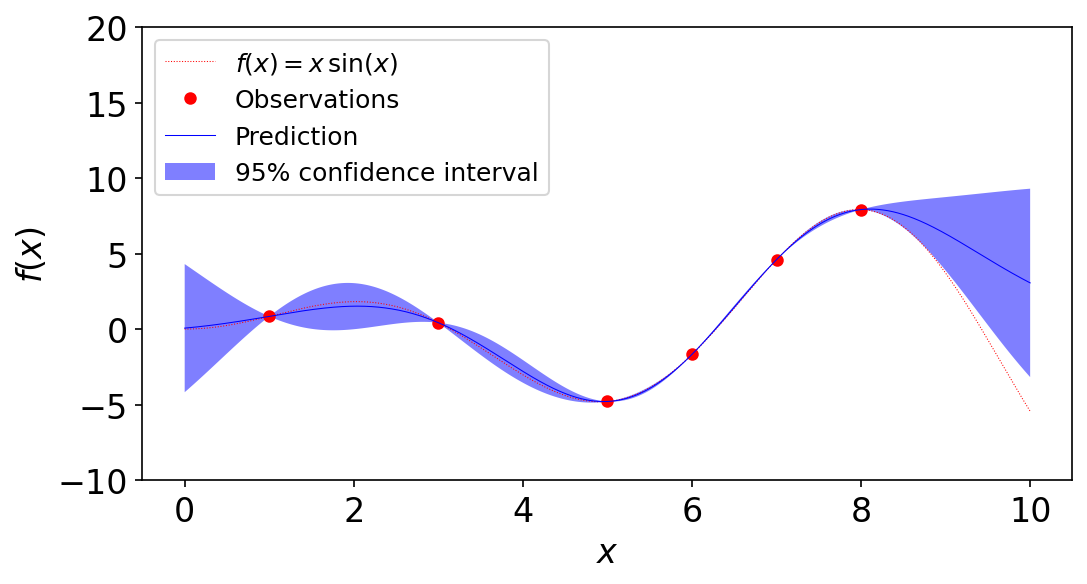

In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    """The function to predict."""
    return x * np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left', prop={'size': 12}); 

Example with noisy data

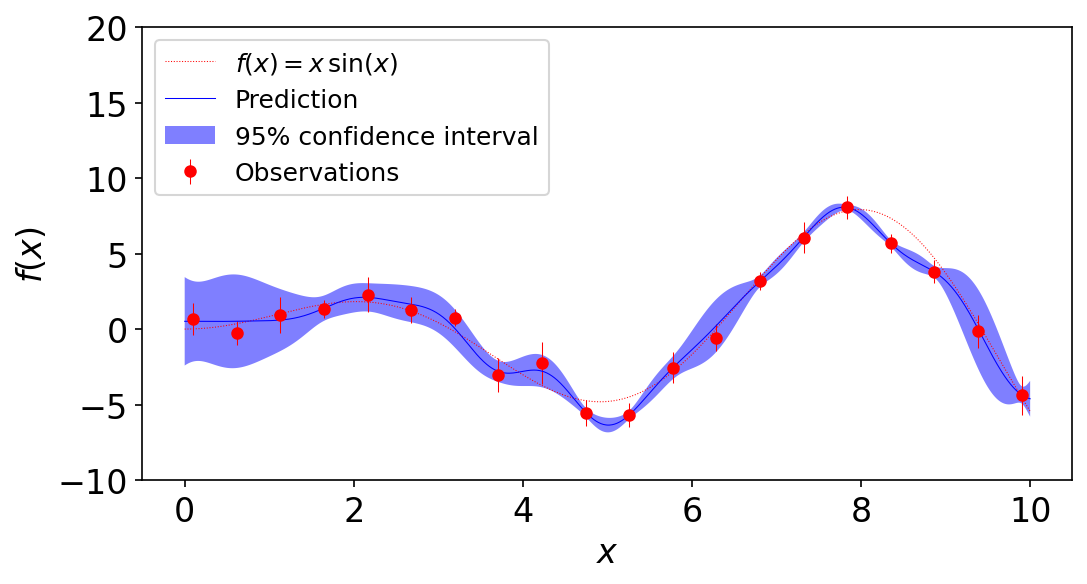

In [40]:
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left', prop={'size': 12})

plt.show() 

## Gaussian processes: Conclusions

Advantages:
- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals.
- The prediction interpolates the observations (at least for regular kernels).
- Versatile: different kernels can be specified.  

Disadvantages:  
- They are typically not sparse, i.e., they use the whole sample/feature information to perform the prediction.
    - Sparse GPs also exist: they remember only the most important points
- They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.



## Gaussian processes and neural networks
* You can prove that a Gaussian process is equivalent to a neural network with one layer and an infinite number of nodes
* You can build _deep Gaussian Processes_ by constructing layers of GPs

<img src="../images/06_deep_gps.png" alt="ml" style="width: 800px;"/>

# Bayesian optimization

- The incremental updates you can do with Bayesian models allow a more effective way to optimize functions
    - E.g. to optimize the hyperparameter settings of a machine learning algorithm/pipeline
- After a number of random search iterations we know more about the performance of hyperparameter settings on the given dataset
- We can use this data to train a model, and predict which other hyperparameter values might be useful
    - More generally, this is called model-based optimization
    - This model is called a _surrogate model_
- This is often a probabilistic (e.g. Bayesian) model that predicts confidence intervals for all hyperparameter settings
- We use the predictions of this model to choose the next point to evaluate
- With every new evaluation, we update the surrogate model and repeat

### Example (see figure): 

- Consider only 1 continuous hyperparameter (X-axis)
    - You can also do this for many more hyperparameters 
- Y-axis shows cross-validation performance
- Evaluate a number of random hyperparameter settings (black dots)
    - Sometimes an initialization design is used
- Train a model, and predict the expected performance of other (unseen) hyperparameter values
    - Mean value (black line) and distribution (blue band)
- An _acquisition function_ (green line) trades off maximal expected performace and maximal uncertainty
    - Exploitation vs exploration
- Optimal value of the asquisition function is the next hyperparameter setting to be evaluated
- Repeat a fixed number of times, or until time budget runs out

<img src="../images/03_Bayesian_optimization.png" alt="ml" style="width: 600px;"/>

In 2 dimensions:  

<img src="../images/05_2dbo.png" alt="ml" style="width: 600px;"/>

## Surrogate models

* Surrogate model can be anything as long as it can do regression and is probabilistic
- Gaussian Processes are commonly used
    - Smooth, good extrapolation, but don't scale well to many hyperparameters (cubic)
    - Sparse GPs: select ‘inducing points’ that minimize info loss, more scalable
    - Multi-task GPs: transfer surrogate models from other tasks
- Random Forests
    - A lot more scalable, but don't extrapolate well
    - Often an interpolation between predictions is used instead of the raw (step-wise) predictions
- Bayesian Neural Networks:
    - Expensive, sensitive to hyperparameters

## Acquisition Functions

- When we have trained the surrogate model, we ask it to predict a number of samples
    - Can be simply random sampling
    - Better: _Thompson sampling_
        - fit a Gaussian distribution (a mixture of Gaussians) over the sampled points
        - sample new points close to the means of the fitted Gaussians
- Typical acquisition function: _Expected Improvement_
    - Models the predicted performance as a Gaussian distribution with the predicted mean and standard deviation
    - Computes the _expected_ performance improvement over the previous best configuration $\mathbf{X^+}$:
$$EI(X) := \mathbb{E}\left[ \max\{0, f(\mathbf{X^+}) - f_{t+1}(\mathbf{X}) \} \right]$$
    - Computing the expected performance requires an integration over the posterior distribution, but has a [closed form solution](http://ash-aldujaili.github.io/blog/2018/02/01/ei/).


# Bayesian Optimization: conclusions

* More efficient way to optimize hyperparameters
* More similar to what humans would do
* Harder to parallellize
* Choice of surrogate model depends on your search space
    - Very active research area
    - For very high-dimensional search spaces, random forests are popular